In [61]:
import numpy as np
import json
import os
import torch
import torchvision
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.autograd.variable import Variable

In [145]:
def pose_to_numpy(frame):
    people = [person[1:] for person in frame]
    return np.array([[body_part[1] for body_part in person] for person in people])

class LetsDanceDataset(torch.utils.data.Dataset):
    categories_hash = {'tango': 0, 'break': 1, 'swing': 2,'quickstep': 3,
                  'foxtrot': 4,'pasodoble': 5,'tap': 6,'samba': 7,'flamenco': 8,
                  'ballet': 9,'rumba': 10,'waltz': 11,'cha': 12,'latin': 13,
                  'square': 14,'jive': 15}
    
    def __init__(self, root_dir, frames):
        super().__init__()

        # frames_index is [category, id, frame_no]
        self.root_dir = root_dir
        self.data = frames_index
        f.close()
        
    def __len__(self):
        return len(self.data)
    
    def getitem_metadata(self, index):
        return self.data[index]
    
    def __getitem__(self, index):
        [category, dance_id, frames] = self.data[index]
        motion = []
        current_frame_path = "{}{}/{}.json".format(self.root_dir, category, dance_id)
        with open(current_frame_path) as f:
            motion = json.load(f)
            # for now, just return person 1 on the first frame, 
            # just to see if it generates any stick figures
            motion = np.array([pose_to_numpy(frame)[0].reshape(34) for frame in motion if len(frame) > 0])
        # only 30 frames
        return (motion[0:30].flatten(), self.categories_hash[category])

In [146]:
with open('./dance-frame-list.json') as f:
    frames_index = json.load(f)
    np.random.shuffle(frames_index)
    
dataloader = LetsDanceDataset("../densepose/full/", frames_index)

In [147]:
def draw_points(points):
    plt.xlim(0, 1980)
    plt.ylim(-1000, 0)
    reshaped = points.reshape(17, 2)
    x = reshaped[:,0]
    y = reshaped[:,1]
    plt.scatter(x, -y, s=10, marker='.',)
    plt.show()

<IPython.core.display.Javascript object>


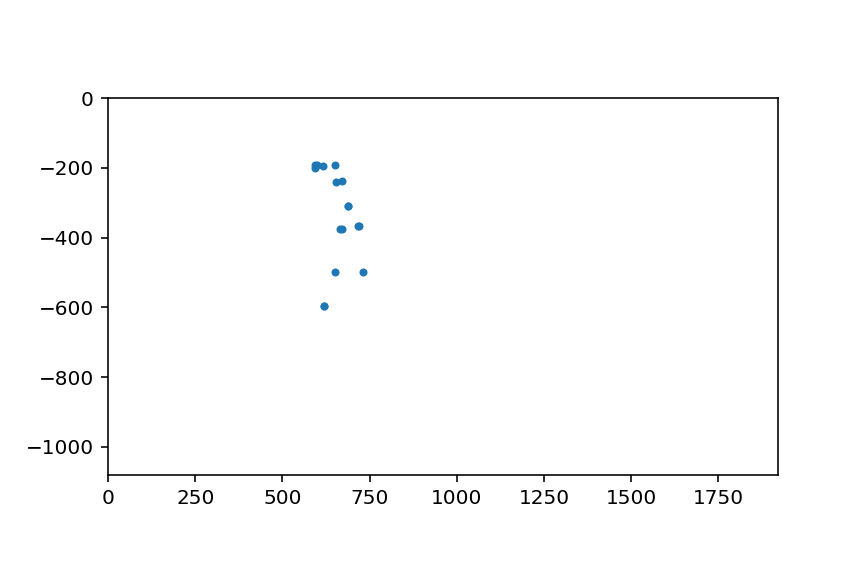

In [149]:
from matplotlib import animation
%matplotlib notebook

motion = dataloader[1000][0]

fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal', autoscale_on=False,
                     xlim=(0,1920), ylim=(-1080, 0))

motion_points = motion.reshape(30, 34)
reshaped = motion_points[0].reshape(17, 2)
x = reshaped[:,0]
y = reshaped[:,1]
body_points, = ax.plot(x, -y, '.')

def animate(frame):
    global body_points, motion_points
    reshaped = motion_points[frame].reshape(17, 2)
    x = reshaped[:,0]
    y = reshaped[:,1]
    body_points.set_data(x, -y)
    return body_points, 

anim = animation.FuncAnimation(fig, animate, frames=len(motion), interval=50)
plt.show()

In [172]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        n_features = 100
        n_out = 34 * 30 # 17 points (* 2 for x and y) * 30 frames
 
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
        

In [173]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        n_features = 34 * 30 
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

In [180]:
def noise(size):
    n = Variable(torch.randn(size, 100))
    if torch.cuda.is_available(): return n.cuda() 
    return n

In [198]:
discriminator = Discriminator()
generator = Generator()
if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()
    
# Optimizers
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

# Loss function
loss = nn.BCELoss()

# Number of steps to apply to the discriminator
d_steps = 1  # In Goodfellow et. al 2014 this variable is assigned to 1
# Number of epochs
num_epochs = 200

In [199]:
def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

In [ ]:
def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    print("real data")
    print(real_data.size())
    print("discriminator")
    print(prediction_real.size())
    # Calculate error and backpropagate
    error_real = loss(prediction_real, real_data_target(1))
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error
    return error_real + error_fake, prediction_real, prediction_fake

def train_generator(optimizer, fake_data):
    # 2. Train Generator
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

num_test_samples = 16
num_batches = len(dataloader)
test_noise = noise(num_test_samples)

def images_to_vectors(images):
    print(images.size())
    return images.view(images.size(0), 30*34)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 30, 34)

for epoch in range(num_epochs):
    for n_batch, (real_batch, label) in enumerate(dataloader):
        real_batch = torch.FloatTensor(real_batch)
        real_data = Variable(real_batch)
        if torch.cuda.is_available(): real_data = real_data.cuda()
        # Generate fake data
        fake_data = generator(noise(real_batch.size(0))).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer,
                                                                real_data, fake_data)
        
        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(real_batch.size(0)))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        print('Epoch {} Error D {} G {}. [{}/{}]'.format(epoch, d_error, g_error, n_batch, num_batches))
        

real data
torch.Size([1020])
discriminator
torch.Size([1])
Epoch 0 Error D 65.52930450439453 G 0.6814019680023193. [0/1463]


/ihome/cs1699-2020s/mav120/.virtualenvs/pytorch/lib/python3.6/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


real data
torch.Size([1020])
discriminator
torch.Size([1])
Epoch 0 Error D 47.527626037597656 G 0.6867434978485107. [1/1463]
real data
torch.Size([1020])
discriminator
torch.Size([1])
Epoch 0 Error D 16.604028701782227 G 0.6852267384529114. [2/1463]
real data
torch.Size([1020])
discriminator
torch.Size([1])
Epoch 0 Error D 0.7065444588661194 G 0.6847463250160217. [3/1463]
real data
torch.Size([1020])
discriminator
torch.Size([1])
Epoch 0 Error D 0.7069656252861023 G 0.684708833694458. [4/1463]
real data
torch.Size([1020])
discriminator
torch.Size([1])
Epoch 0 Error D 0.7071636915206909 G 0.6844626665115356. [5/1463]
real data
torch.Size([1020])
discriminator
torch.Size([1])
Epoch 0 Error D 0.7072539329528809 G 0.6853109002113342. [6/1463]
real data
torch.Size([1020])
discriminator
torch.Size([1])
Epoch 0 Error D 0.7066923379898071 G 0.6872216463088989. [7/1463]
real data
torch.Size([1020])
discriminator
torch.Size([1])
Epoch 0 Error D 0.7052513360977173 G 0.6896350383758545. [8/1463]
r

Epoch 0 Error D 28.010732650756836 G 1.359055757522583. [66/1463]
real data
torch.Size([1020])
discriminator
torch.Size([1])
Epoch 0 Error D 28.020254135131836 G 1.317018985748291. [67/1463]
real data
torch.Size([1020])
discriminator
torch.Size([1])
Epoch 0 Error D 28.041444778442383 G 1.2878413200378418. [68/1463]
real data
torch.Size([1020])
discriminator
torch.Size([1])
Epoch 0 Error D 28.063129425048828 G 1.251094937324524. [69/1463]
real data
torch.Size([1020])
discriminator
torch.Size([1])
Epoch 0 Error D 28.08121681213379 G 1.2084767818450928. [70/1463]
real data
torch.Size([1020])
discriminator
torch.Size([1])
Epoch 0 Error D 28.097042083740234 G 1.1949653625488281. [71/1463]
real data
torch.Size([1020])
discriminator
torch.Size([1])
Epoch 0 Error D 28.106285095214844 G 1.1667503118515015. [72/1463]
real data
torch.Size([1020])
discriminator
torch.Size([1])
Epoch 0 Error D 28.1053524017334 G 1.1800035238265991. [73/1463]
real data
torch.Size([1020])
discriminator
torch.Size([1]

real data
torch.Size([1020])
discriminator
torch.Size([1])
Epoch 0 Error D 27.833599090576172 G 1.7600926160812378. [132/1463]
real data
torch.Size([1020])
discriminator
torch.Size([1])
Epoch 0 Error D 27.825685501098633 G 1.7818812131881714. [133/1463]
real data
torch.Size([1020])
discriminator
torch.Size([1])
Epoch 0 Error D 27.820131301879883 G 1.813137173652649. [134/1463]
real data
torch.Size([1020])
discriminator
torch.Size([1])
Epoch 0 Error D 27.81387710571289 G 1.8500051498413086. [135/1463]
real data
torch.Size([1020])
discriminator
torch.Size([1])
Epoch 0 Error D 27.80877113342285 G 1.8698375225067139. [136/1463]
real data
torch.Size([1020])
discriminator
torch.Size([1])
Epoch 0 Error D 27.805469512939453 G 1.8987102508544922. [137/1463]
real data
torch.Size([1020])
discriminator
torch.Size([1])
Epoch 0 Error D 27.799043655395508 G 1.916467308998108. [138/1463]
real data
torch.Size([1020])
discriminator
torch.Size([1])
Epoch 0 Error D 27.79972267150879 G 1.928289771080017. [

Epoch 0 Error D 27.660507202148438 G 3.712268352508545. [197/1463]
real data
torch.Size([1020])
discriminator
torch.Size([1])
Epoch 0 Error D 27.660688400268555 G 3.6489970684051514. [198/1463]
real data
torch.Size([1020])
discriminator
torch.Size([1])
Epoch 0 Error D 27.6610050201416 G 3.6436927318573. [199/1463]
real data
torch.Size([1020])
discriminator
torch.Size([1])
Epoch 0 Error D 27.66166877746582 G 3.6585533618927. [200/1463]
real data
torch.Size([1020])
discriminator
torch.Size([1])
Epoch 0 Error D 27.662246704101562 G 3.609135389328003. [201/1463]
real data
torch.Size([1020])
discriminator
torch.Size([1])
Epoch 0 Error D 27.663150787353516 G 3.5822255611419678. [202/1463]
real data
torch.Size([1020])
discriminator
torch.Size([1])
Epoch 0 Error D 27.66417121887207 G 3.546670436859131. [203/1463]
real data
torch.Size([1020])
discriminator
torch.Size([1])
Epoch 0 Error D 27.664501190185547 G 3.5461645126342773. [204/1463]
real data
torch.Size([1020])
discriminator
torch.Size([1

real data
torch.Size([1020])
discriminator
torch.Size([1])
Epoch 0 Error D 27.64338493347168 G 4.686028957366943. [263/1463]
real data
torch.Size([1020])
discriminator
torch.Size([1])
Epoch 0 Error D 27.643308639526367 G 4.675999164581299. [264/1463]
real data
torch.Size([1020])
discriminator
torch.Size([1])
Epoch 0 Error D 27.643718719482422 G 4.652263164520264. [265/1463]
real data
torch.Size([1020])
discriminator
torch.Size([1])
Epoch 0 Error D 27.644067764282227 G 4.641271591186523. [266/1463]
real data
torch.Size([1020])
discriminator
torch.Size([1])
Epoch 0 Error D 27.643970489501953 G 4.665791034698486. [267/1463]
real data
torch.Size([1020])
discriminator
torch.Size([1])
Epoch 0 Error D 27.64348030090332 G 4.675817966461182. [268/1463]
real data
torch.Size([1020])
discriminator
torch.Size([1])
Epoch 0 Error D 27.643287658691406 G 4.69298791885376. [269/1463]
real data
torch.Size([1020])
discriminator
torch.Size([1])
Epoch 0 Error D 27.642532348632812 G 4.777114391326904. [270/1